## Import required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
dataset_path = '/kaggle/input/phishing-url'
dataset_files = os.listdir(dataset_path)
print("Files in the dataset folder:", dataset_files)

csv_file_path = os.path.join(dataset_path, dataset_files[0])   # Replace 'example.csv' with your file name
df = pd.read_csv(csv_file_path)

Files in the dataset folder: ['Data_processed.csv']


In [3]:
df.dtypes

url                            object
login_form                      int64
links_in_tags                 float64
submit_email                    int64
sfh                             int64
iframe                          int64
popup_window                    int64
safe_anchor                   float64
onmouseover                     int64
right_clic                      int64
whois_registered_domain         int64
domain_registration_length      int64
domain_age                      int64
web_traffic                     int64
dns_record                      int64
google_index                    int64
page_rank                       int64
status                         object
embedded_domain                 int64
having_ip_address               int64
no_of_dots                      int64
lexical_features               object
no_of_sensitive_words           int64
out_of_position_tld             int64
https_token                     int64
url_length                      int64
tinyURL     

## Remove columns with non-integer data types

In [4]:
df.drop(columns=['url','lexical_features','submit_email','sfh'], inplace=True)

In [5]:
df.columns

Index(['login_form', 'links_in_tags', 'iframe', 'popup_window', 'safe_anchor',
       'onmouseover', 'right_clic', 'whois_registered_domain',
       'domain_registration_length', 'domain_age', 'web_traffic', 'dns_record',
       'google_index', 'page_rank', 'status', 'embedded_domain',
       'having_ip_address', 'no_of_dots', 'no_of_sensitive_words',
       'out_of_position_tld', 'https_token', 'url_length', 'tinyURL',
       'prefixSuffix'],
      dtype='object')

## Standardization of data

In [6]:
scaler = StandardScaler()
# Select columns to standardize
columns_to_standardize = df.columns.tolist()
columns_to_standardize.remove('status')

# Initialize StandardScaler
# scaler = StandardScaler()

# Fit and transform the selected columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

## Train-test Split

In [7]:
df['target'] = np.where(df['status'] == 'phishing', 1, -1)
df.drop(columns=['status'], inplace=True)
Y=df['target']
X = df.drop(columns=['target'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0) # creating testing and training set

## Defining evaluation metrics

In [9]:
def confusion_matrix(actual, predicted):
    if not isinstance(predicted, np.ndarray):
        predicted=np.array(predicted)
    matrix = np.zeros((2,2))
    n_samples = actual.shape[0]
    for i in range(n_samples):
        if actual.iloc[i] == predicted[i] and actual.iloc[i] == 1:
            matrix[0,0] += 1  # True Positive
        elif actual.iloc[i] == predicted[i]:
            matrix[1,1] += 1  # True Negative
        elif predicted[i] == 1:
            matrix[0,1] += 1  # False Positive
        else:
            matrix[1,0] += 1  # False Negative
    
    # Calculate precision, recall, and F1 score
    precision = matrix[0,0] / (matrix[0,0] + matrix[0,1]) if (matrix[0,0] + matrix[0,1]) > 0 else 0
    recall = matrix[0,0] / (matrix[0,0] + matrix[1,0]) if (matrix[0,0] + matrix[1,0]) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = np.sum(np.diag(matrix)) / np.sum(matrix) 

    labels = ['Actual Positive', 'Actual Negative']
    print("\t\tPredicted Positive\tPredicted Negative")
    for i, row_label in enumerate(labels):
        print(f"{row_label}\t\t{int(matrix[i,0])}\t\t\t{int(matrix[i,1])}")

    # Print precision, recall, and F1 score
    print("\nPrecision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    print("Accuracy:", accuracy)



<hr>
<center><h1> Creating SVM models </h1></center>


<hr>
<center><h1> Linear SVM: Hard Margin Classifier
</h1></center>

For n-dimensional feature space, SVM creates an n-1 dimensional hyperplane to seprate the classes.
Any hyperplane can be represented as:

$$
w^T X - b = 0
$$


![](https://adeveloperdiary.com/assets/img/Support-Vector-Machine-for-Beginners-Hard-Margin-Classifier-adeveloperdiary.com_.jpg)

If the dataset can be linearly sperated, we can create two parallel hyperplane(lines here) for each classes and contain each data points under these hyperplanes and our goal would be to maximize the distance between these two parallel hyperplane. The region between these two plane is called **margin**. The equations for both hyperplane is:

$$
w^T X - b = -1
$$
$$
w^T X - b = 1
$$

The distance between them is 2/||w|| and to maximize the distance, ||w|| should be minimum. 

To prevent any data point falling inside margin we add the restriction,

$$
y_i(w^T X_i - b) \geq 1
$$

where y<sub>i</sub> = ith row in y
and X<sub>i</sub> = ith row in X

<div align="center">

### Objective Function:
$$
\min_{w} \left( \frac{||w||^2}{2} \right)
$$

### Linear Constraint:
$$
y_i (w^T x_i - b) \geq 1
$$

</div>

<hr>
<center><h1> Linear SVM: Soft Margin Classifier
</h1></center>


![](https://adeveloperdiary.com/assets/img/Support-Vector-Machine-for-Beginners-Hard-Margin-Classifier-adeveloperdiary.com-1-.jpg)

We have assumed that the dataset is perfectly linearly separable, which doesn’t really happen in real scenario. Some of the classes overlap such way that a perfect separation is impossible. Thera are mainly two possibilities:
1) Single outlier can push the decision boundary greatly, so that the margin becomes very narrow.

2) Even though a linear decision boundary can classify the target classes properly, the data may not be separable using a straight line.

### Slack Variable

We can solve this problem by introducing a new variable named Slack Variable and then redefine our inequality constraint as,

$$
y_i(w^T X_i - b) \geq 1 - \xi_i
$$


where ξ<sub>i</sub> is the slack variable for the point X<sub>i.

<div align="center">

### Objective Function:
$$
\min_{w, b, \xi_i} \left( \frac{||w||^2}{2} + C\sum_{i=1}^{n} \xi_i \right)
$$

### Linear Constraint:
$$
y_i (w^T x_i - b) \geq 1 - \xi_i, \quad \text{where} \quad \xi_i \geq 0
$$

</div>

C and k are constants which balance the cost of misclassification. C is a hyperparameter which controls the trade-off between maximizing the margin and minimizing the loss.
    
We can’t use Gradient Descent to optimize the Soft Margin Objective Function due to the inequality constraint. Hence need to first find a way to change the constraint to equality constraint.
    
So, we use hinge loss for loss function: <br>
$$
\xi_i = \max(0, 1 - y_i (w^T x_i - b))
$$

If the datapoint has class = 1, then the loss will be 0, otherwise it will be the distance between the margin and the datapoint.
    
![](https://i2.wp.com/www.adeveloperdiary.com/wp-content/uploads/2020/04/Support-Vector-Machine-for-Beginners-Hard-Margin-Classifier-adeveloperdiary.com-13.jpg?resize=420%2C338&ssl=1)

and our goal is to minimize

$$
L = ||w||^2 + C \sum_{i=1} \max(0, 1 - y_i (\beta^T x_i - b))
$$
 OR   
$$
L = \lambda ||w||^2 + \sum_{i=1} \max(0, 1 - y_i (\beta^T x_i - b))
$$


### Updating weights

In order to find the minima, we need to take derivative w.r.t w and b and then use them in Gradient Descent formula

<span style="background-color:transparent">Case 1: y<sub>i</sub>(w<sup>T</sup>X<sub>i</sub> -b) ≥ 1</span>
$$
    dw = 2\lambda w
$$
    $$
    db = 0
    $$

<span style="background-color:transparent">Case 2:y<sub>i</sub>(w<sup>T</sup>X<sub>i</sub> -b) < 1
</span>
$$
    dw = 2\lambda w - y_i x_i
$$
    $$
    db = y_i
    $$

In [10]:
class SVM_soft_margin:

    def __init__(self, alpha = 0.001, lambda_ = 0.01, n_iterations = 500):
        self.alpha = alpha # learning rate
        self.lambda_ = lambda_ # tradeoff
        self.n_iterations = n_iterations # number of iterations
        self.w = None # weights or slopes
        self.b = None # intercept


    def fit(self, X, y):
        
        n_samples, n_features = X.shape       
        self.w = np.zeros(n_features) # initalizing with 0
        self.b = 0 # initialize with 0
        
        for iteration in range(self.n_iterations):
            for i, Xi in X.iterrows():
                # yi(xiw-b)≥1
                if y[i] * (np.dot(Xi, self.w) - self.b) >= 1 : 
                    self.w -= self.alpha * (2 * self.lambda_ * self.w) # w = w + α* (2λw)
                else:
                    self.w -= self.alpha * (2 * self.lambda_ * self.w - np.dot(Xi, y[i])) # w = w + α* (2λw - yixi)
                    self.b -= self.alpha * y[i] # b = b - α* (yi)
        return self.w, self.b


    def predict(self, X):
        pred = np.dot(X, self.w) - self.b 
        result = [1 if val > 0 else -1 for val in pred] # returning in the form of -1 and 1
        return result

In [11]:
svm = SVM_soft_margin()   # Initialize svm classifier
w,b = svm.fit(X_train,y_train)   # training
y_pred = svm.predict(X_test)    # prediction

In [12]:
confusion_matrix(y_test, y_pred)

		Predicted Positive	Predicted Negative
Actual Positive		1024			173
Actual Negative		107			982

Precision: 0.8554720133667502
Recall: 0.905393457117595
F1 Score: 0.8797250859106529
Accuracy: 0.8775153105861767


<hr>
<br><br>
<center><h2> SVM using PEGASOS and Stochastic Gradient Descent </h2></center>

![j](https://miro.medium.com/max/700/1*R1GhsOV0UuMbnTwx8A47Zw.jpeg)

The above equation shows Pegasos algorithm, which is used with Stochastic Gradient Descent. We use Pegasos algorithm with stochastic gradient descent for faster convergence.
For implementing Stochastic Gradient Descent, we will append one more feature containing 1 to X and we will remove b. Thus, our equation <br>

y = w<sub>1</sub>X<sub>1</sub> + w<sub>2</sub>X<sub>2</sub> - b <br>

will change to<br>

y = w<sub>0</sub>X<sub>0</sub> + w<sub>1</sub>X<sub>1</sub> + w<sub>2</sub>X<sub>2</sub> <br>

but as x<sub>0</sub> = 1, thus w<sub>0</sub> = -b

<br>

In [13]:
# implementing SVM using Stochastic Gradient Descent and Pegasos algorithms

def SVM_SGD(X,Y,lambda_,epoches):
    
    X = np.c_[np.ones(X.shape[0]), X] # adding feature containing 1
    w = np.zeros(X.shape[1]) # initializing w with 0s
    
    # converting arrays to matrix
    X = np.matrix(X)
    Y = np.matrix(Y) 
    Y = Y.T
    w = np.matrix(w)

    for t in range(1,epoches+1):
        
        # choosing random points
        random_pos = random.randrange(0, X.shape[0]-1)
        x = X[random_pos,:]
        y = Y[random_pos,:]
    
        # computing eta and finding class
        eta = 1/(lambda_*t)
        cls = y * (w*x.T)

        if cls < 1:
            w = (1 - eta*lambda_)*w + eta*y*x
        elif cls >= 1:
            w = (1 - eta*lambda_)*w

    pred = w*X.T
    # converting matrix back to array
    pred = np.array(pred)
    return np.array(w)[0]
        

In [14]:
w = SVM_SGD(X_train,y_train,lambda_ = 0.01,epoches = 1000)

# Add bias feature to test data
X_test_bias = np.c_[np.ones(X_test.shape[0]), X_test]

# Predict labels for test data
pred = np.dot(X_test_bias, w)

result = [1 if val > 0 else -1 for val in pred]


In [15]:
accuracy_score(result,y_test)

0.8722659667541557

<br><br>
<hr>
<br><br>
<center><h2>SVM for Non-Linear Dataset using Kernel</h2><center>

![](https://adeveloperdiary.com/assets/img/Support-Vector-Machine-for-Beginners-Hard-Margin-Classifier-adeveloperdiary.com-0-.jpg)

We can use Linear Classifier for Non Linear Classification by expanding the input space to a feature space. We can use the Kernel Trick to implement Non Linear SVM, without the need to have any higher dimensional feature vector (Less time and space complexity) . The Objective Function of Primal Problem works fine for Linearly Separable Dataset, however doesn’t solve Non-Linear Dataset. However our final goal is to solve Non-Linear SVM where Primal Problem is not helpful. In order to find a solution,we generally solve its dual problem.

## Polynomial Kernel
$$
K_q(x, z) = (c + x^Tz)^q
$$

## Gaussian Kernel
$$
K(x, z) = \exp \left\{ - \frac{||x - z||^2}{2\sigma^2} \right\}
$$
It is important to note that the feature space of Gaussian Kernel has Infinite Dimensionality.

## Loss
The Dual Lagrangian loss function which we are trying to maximize is:

$$
L_{\text{dual}} = \sum \alpha_i - \frac{1}{2} \sum_i \sum_j \alpha_i \alpha_j y_i y_j K(x_i, x_j)
$$

## Gradient

Differentiating the loss wrt α<sub>k</sub> , using kth term for Gradient Ascent:

$$
\frac{\delta L_{\text{dual}}}{\delta \alpha_k} = 1 - y_k \sum_j \alpha_j y_j K(x_j, x_k)
$$

where, <br>

K(x<sub>i</sub>, x<sub>j</sub>) is our Kernel function which could be linear, polynomial or gaussian(rbf).

## Updates

α = α + η*(gradient)

where η = learning rate

After training, calculate intercept b:

$$
b = \text{avg}_{0 \leq \alpha_i \leq C} \left\{ y_i - \sum_j \alpha_j y_j K(x_j, x_i) \right\}
$$


## Prediction

For α>0 :

$$
\hat{y} = \text{sign} \left( \sum \alpha_i y_i k(x_i, x_i) + b \right)
$$



In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.45,random_state=0) # creating testing and training set

In [17]:
class SVM_Dual:

    def __init__(self, kernel='poly', degree=2, sigma=1, epoches=250, learning_rate= 0.01, gamma = 0.1):
        self.alpha = None
        self.b = 0
        self.degree = degree
        self.c = 75
        self.C = 1
        self.sigma = sigma
        self.epoches = epoches
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.iter = []
        self.loss = []

        if kernel == 'poly':
            self.kernel = self.polynomial_kernal # for polynomial kernal
        elif kernel == 'rbf':
            self.kernel =  self.gaussian_kernal # for guassian
        elif kernel == 'tanh':
            self.kernel = self.tanh_kernel
        elif kernel == 'laplace':
            self.kernel = self.laplacian_kernel
        elif kernel == 'cosine':
            self.kernel = self.cosine_similarity_kernel

    def polynomial_kernal(self,X,Z):
        return (self.c + X.dot(Z.T))**self.degree #(c + X.y)^degree

    
    def tanh_kernel(self, X, Z):
        # Compute the dot product between X and Z
        dot_product = X.dot(Z.T)
        K = np.tanh(self.gamma * dot_product + self.c)

        return K
    
    def gaussian_kernal(self, X,Z):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(Z, pd.DataFrame):
            Z = Z.to_numpy()
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X[:, np.newaxis] - Z[np.newaxis, :], axis=2) ** 2) #e ^-(1/ σ2) ||X-y|| ^2
    
    def laplacian_kernel(self, X,Z):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(Z, pd.DataFrame):
            Z = Z.to_numpy()
        return np.exp(-(1 / self.sigma ) * np.linalg.norm(X[:, np.newaxis] - Z[np.newaxis, :], axis=2)) #e ^-(1/ σ2) ||X-y|| ^2
    
    def train(self,X,y):
        self.X = X
        self.y = y
        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        self.ones = np.ones(X.shape[0]) 

        y_mul_kernal = np.outer(y, y) * self.kernel(X, X) # yi yj K(xi, xj)

        for i in range(self.epoches):
            gradient = self.ones - y_mul_kernal.dot(self.alpha) # 1 – yk ∑ αj yj K(xj, xk)

            self.alpha += self.learning_rate * gradient # α = α + η*(1 – yk ∑ αj yj K(xj, xk)) to maximize
            self.alpha[self.alpha > self.C] = self.C # 0<α<C
            self.alpha[self.alpha < 0] = 0 # 0<α<C

            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_mul_kernal) # ∑αi – (1/2) ∑i ∑j αi αj yi yj K(xi, xj)
            if i%10 ==0:
                self.iter.append(i)
                self.loss.append(loss)
            
        alpha_index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        
        # for intercept b, we will only consider α which are 0<α<C 
        b_list = []        
        for index in alpha_index:
            b_list.append(y.iloc[index] - (self.alpha * y).dot(self.kernel(X, X.iloc[index])))

        self.b = np.mean(b_list) # avgC≤αi≤0{ yi – ∑αjyj K(xj, xi) }
            
    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    
    def decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

## Training SVM with RBF kernel

In [18]:
svm_dual = SVM_Dual(kernel='rbf')
svm_dual.train(X_train,y_train)
y_pred=svm_dual.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


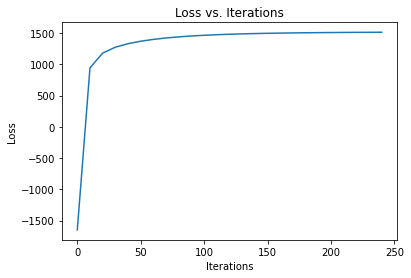

In [19]:
plt.plot(svm_dual.iter, svm_dual.loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.show()

In [20]:
confusion_matrix(y_test,y_pred)

		Predicted Positive	Predicted Negative
Actual Positive		2238			168
Actual Negative		327			2411

Precision: 0.9301745635910225
Recall: 0.8725146198830409
F1 Score: 0.900422450211225
Accuracy: 0.9037713841368584


## Training SVM with Polynomial Kernel

In [21]:
svm_dual_poly = SVM_Dual(kernel='poly', degree=2)
svm_dual_poly.train(X_train,y_train)
y_pred=svm_dual_poly.predict(X_test)

In [22]:
confusion_matrix(y_test,y_pred)

		Predicted Positive	Predicted Negative
Actual Positive		2464			1278
Actual Negative		101			1301

Precision: 0.6584714056654195
Recall: 0.9606237816764133
F1 Score: 0.7813540510543839
Accuracy: 0.7319206842923794


## SVM With Mini-Batch Gradient Descent

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0) # creating testing and training set

In [24]:
class SVM_Dual_Batch:

    def __init__(self, kernel='poly', degree=2, sigma=1, epoches=250, learning_rate= 0.01, batch_size = 4096):
        self.alpha = None
        self.b = 0
        self.degree = degree
        self.c = 75
        self.C = 1
        self.sigma = sigma
        self.epoches = epoches
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.iter=[]
        self.loss=[]

        if kernel == 'poly':
            self.kernel = self.polynomial_kernal # for polynomial kernal
        elif kernel == 'rbf':
            self.kernel =  self.gaussian_kernal # for guassian
        elif kernel == 'tanh':
            self.kernel = self.tanh_kernel
        elif kernel == 'laplace':
            self.kernel = self.laplacian_kernel
        elif kernel == 'cosine':
            self.kernel = self.cosine_similarity_kernel

    def polynomial_kernal(self,X,Z):
        return (self.c + X.dot(Z.T))**self.degree #(c + X.y)^degree


    def tanh_kernel(self, X, Z):
        # Compute the dot product between X and Z
        dot_product = X.dot(Z.T)
        K = np.tanh(self.gamma * dot_product + self.c)

        return K
    
    def gaussian_kernal(self, X,Z):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(Z, pd.DataFrame):
            Z = Z.to_numpy()
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X[:, np.newaxis] - Z[np.newaxis, :], axis=2) ** 2) #e ^-(1/ σ2) ||X-y|| ^2
    
    def laplacian_kernel(self, X,Z):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(Z, pd.DataFrame):
            Z = Z.to_numpy()
        return np.exp(-(1 / self.sigma ) * np.linalg.norm(X[:, np.newaxis] - Z[np.newaxis, :], axis=2)) #e ^-(1/ σ2) ||X-y|| ^2
    
    def cosine_similarity_kernel(self, X, Z):
        # Compute the dot product between X and Z
        dot_product = X.dot(Z.T)

        # Compute the norms of X and Z
        norm_X = np.linalg.norm(X, axis=1)
        norm_Z = np.linalg.norm(Z, axis=1)

        # Compute the cosine similarity kernel
        cosine_similarity = dot_product / np.outer(norm_X, norm_Z)

        return cosine_similarity

    
    def train(self,X,y):
        self.X = X
        self.y = y
        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        self.ones = np.ones(X.shape[0]) 

        for i in range(self.epoches):
            for batch_start in range(0, X.shape[0], self.batch_size):
                batch_end = min(batch_start + self.batch_size, X.shape[0])
                X_batch = X.iloc[batch_start:batch_end]
                y_batch = y.iloc[batch_start:batch_end]

                y_mul_kernel_batch = np.outer(y_batch, y_batch) * self.kernel(X_batch, X_batch)  # yi yj K(xi, xj)
                gradient = self.ones[batch_start:batch_end] - y_mul_kernel_batch.dot(self.alpha[batch_start:batch_end])  # 1 – yk ∑ αj yj K(xj, xk)

                self.alpha[batch_start:batch_end] += self.learning_rate * gradient  # α = α + η*(1 – yk ∑ αj yj K(xj, xk)) to maximize
                self.alpha[self.alpha > self.C] = self.C  # 0<α<C
                self.alpha[self.alpha < 0] = 0  # 0<α<C
                loss = np.sum(self.alpha[batch_start:batch_end]) - 0.5 * np.sum(np.outer(self.alpha[batch_start:batch_end], self.alpha[batch_start:batch_end]) * y_mul_kernel_batch) # ∑αi – (1/2) ∑i ∑j αi αj yi yj K(xi, xj)
                if i%10 ==0 and batch_start == self.batch_size:
                    self.iter.append(i)
                    self.loss.append(loss)

        alpha_index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        
        # for intercept b, we will only consider α which are 0<α<C 
        b_list = []        
        for index in alpha_index:
            b_list.append(y.iloc[index] - (self.alpha * y).dot(self.kernel(X, X.iloc[index])))

        self.b = np.mean(b_list) # avgC≤αi≤0{ yi – ∑αjyj K(xj, xi) }
            
    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    
    def decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

In [25]:
svm_batch = SVM_Dual_Batch(kernel = 'rbf')
svm_batch.train(X_train,y_train)
y_pred=svm_batch.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


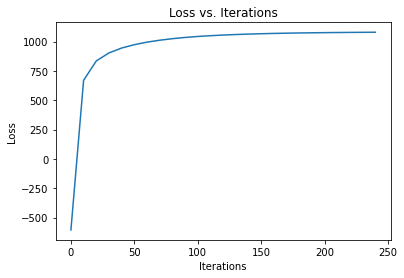

In [26]:
plt.plot(svm_batch.iter, svm_batch.loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.show()

In [27]:
confusion_matrix(y_test,y_pred)

		Predicted Positive	Predicted Negative
Actual Positive		966			69
Actual Negative		165			1086

Precision: 0.9333333333333333
Recall: 0.8541114058355438
F1 Score: 0.8919667590027701
Accuracy: 0.8976377952755905


In [28]:
svm_poly_batch = SVM_Dual_Batch(kernel='poly', degree=2)
svm_poly_batch.train(X_train,y_train)
y_pred=svm_poly_batch.predict(X_test)

In [29]:
confusion_matrix(y_test,y_pred)

		Predicted Positive	Predicted Negative
Actual Positive		907			92
Actual Negative		224			1063

Precision: 0.9079079079079079
Recall: 0.801945181255526
F1 Score: 0.8516431924882629
Accuracy: 0.8617672790901137


## Results of standard SVM implementation

In [30]:
# Training
svm_lin = SVC(kernel='linear') 
svm_lin.fit(X_train, y_train) 

svm_poly = SVC(kernel='poly') 
svm_poly.fit(X_train, y_train) 

svm_rbf = SVC(kernel='rbf') 
svm_rbf.fit(X_train, y_train)

svm_tanh= SVC(kernel='sigmoid')
svm_tanh.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [31]:
print("Accuracy of linear kernel:" ,accuracy_score(svm_lin.predict(X_test),y_test))
print("Accuracy of polynomial kernel:" ,accuracy_score(svm_poly.predict(X_test),y_test))
print("Accuracy of RBF kernel:" ,accuracy_score(svm_rbf.predict(X_test),y_test))
print("Accuracy of sigmoid kernel:" ,accuracy_score(svm_tanh.predict(X_test),y_test))

Accuracy of linear kernel: 0.8853893263342082
Accuracy of polynomial kernel: 0.9164479440069991
Accuracy of RBF kernel: 0.9273840769903762
Accuracy of sigmoid kernel: 0.8258967629046369


<hr>
<br><br>
<center><h2> Sequential Minimal Optimization (SMO) </h2></center>

SMO chooses to solve the smallest possible optimization problem at every step. For the standard SVM QP problem, the smallest possible optimization problem involves two Lagrange multipliers, because the Lagrange multipliers must obey a linear equality constraint. At every step, SMO chooses two Lagrange multipliers to jointly optimize, finds the optimal values for these multipliers, and updates the SVM to reflect the new optimal values. SMO requires no extra matrix storage at all. Thus, very large SVM training problems can fit inside of the memory of an ordinary personal computer or workstation.

There are two components to SMO: an analytic method for solving for the two Lagrange multipliers, and a heuristic for choosing which multipliers to optimize.


## Coordinate Ascend
Keep all but α<sub>1</sub> fixed and chose α<sub>2</sub> to maximize
$$
L_{\text{dual}} = \sum \alpha_i - \frac{1}{2} \sum_i \sum_j \alpha_i \alpha_j y_i y_j K(x_i, x_j)
$$
while ensuring all constraints remain satisfied.

<span style="color:red; font-size: 20px;">Issue:</span>

$\sum_{i=1}^{n} \alpha_i y_i = 0$
forces $\alpha_1 = \frac{\sum_{i \neq 1} \alpha_i y_i}{y_1}$ so we cannot change α<sub>1</sub>.

### Ascend on two coordinates
Keep all but α<sub>1</sub>,α<sub>2</sub> fixed and chose α<sub>1</sub>,α<sub>2</sub> to maximize
$$
L_{\text{dual}} = \sum \alpha_i - \frac{1}{2} \sum_i \sum_j \alpha_i \alpha_j y_i y_j K(x_i, x_j)
$$
while ensuring all constraints remain satisfied.

$\sum_{i=1}^{n} \alpha_i y_i = 0$
forces $\alpha_1 y_1 + \alpha_2 y_2 = \sum_{i \neq 1, 2} \alpha_i y_i$ = &delta;


This gives $\alpha_2 = \frac{\delta - \alpha_1 y_1}{y_2}$



![](https://www.researchgate.net/publication/2624239/figure/fig1/AS:341172695388163@1458353317827/The-two-Lagrange-multipliers-must-fulfill-all-of-the-constraints-of-the-full-problem-The.png)

The two Lagrange multipliers must fulfill all of the constraints of the full problem. The inequality constraints cause the Lagrange multipliers to lie in the box. The linear equality constraint causes them to lie on a diagonal line. Therefore, one step of SMO must find an optimum of the objective function on a diagonal line segment.

If the target y1 does not equal the target y2, then the following bounds apply to α2:
$$ L = \max(0, \alpha_{2}-\alpha_{1}) $$ 

$$ R = \min(C, C + \alpha_{2}-\alpha_{1}) $$

If the target y1 equals the target y2, then the following bounds apply to α2:

$$ L = \max(0, \alpha_{2}+\alpha_{1} - C) $$ 

$$ R = \min(C, C + \alpha_{2}+\alpha_{1}) $$

The second derivative of the objective function along the diagonal line can be expressed as:

$$ η = K(x_1, x_1) + K(x_2, x_2) - 2K(x_1, x_2)
$$

We use gradient descent to find the updates in the value of α<sub>2</sub>.

$$\alpha_2^{new} = \alpha_2 + \frac{y_2(E_1 - E_2)}{η}$$

where E<sub>i</sub> = u<sub>i</sub> - y<sub>i</sub> is the error on the i<sup>th</sup> training example.

As a next step, the constrained minimum is found by clipping the unconstrained minimum to the ends of the line segment:

$$\alpha_2^{new,clipped} = min(R, max(L,\alpha_2^{new}))$$

The value of α<sub>1</sub> is computed from the new, clipped, α<sub>2</sub>:

$$\alpha_1^{new} = \alpha_1 + y_1 y_2 (\alpha_2 - \alpha_2^{new,clipped})$$

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4,random_state=0) # creating testing and training set

In [33]:
class SVM_SMO:

    def __init__(self, kernel='poly', degree=2, sigma=1, epoches=250, learning_rate= 0.01, epsilon=0.001):
        self.alpha = None
        self.b = 0
        self.degree = degree
        self.c = 75
        self.C = 1
        self.sigma = sigma
        self.epoches = epoches
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.iter=[]
        self.loss=[]
        
        if kernel == 'linear':
            self.kernel=self.linear_kernel
        elif kernel == 'poly':
            self.kernel = self.polynomial_kernel
        elif kernel == 'rbf':
            self.kernel =  self.gaussian_kernel
            
    def linear_kernel(self,X,Z):
        return X.dot(Z.T)
    
    def polynomial_kernel(self,X,Z):
        return (self.c + X.dot(Z.T))**self.degree  #(c + X.y)^degree
    
    def gaussian_kernel(self, X,Z):
        return np.exp(- (np.linalg.norm(X - Z, 2)) ** 2 / (2 * self.sigma ** 2))

    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))
    
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    
    def compute_limits(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    
    def train(self,X,y):
        self.X = X
        self.y = y
        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        n, d = X.shape[0], X.shape[1]
        for count in range(self.epoches):
            alpha_prev = np.copy(self.alpha)
            for j in range(0, n):
                i = j
                while i==j:
                    i = random.randint(0,n-1)
                x_i, x_j, y_i, y_j = X.iloc[i], X.iloc[j], y.iloc[i], y.iloc[j]
                k_ij = self.kernel(x_i, x_i) + self.kernel(x_j, x_j) - 2 * self.kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = self.alpha[j], self.alpha[i]
                (L, R) = self.compute_limits(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(self.alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                self.alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                self.alpha[j] = max(self.alpha[j], L)
                self.alpha[j] = min(self.alpha[j], R)

                self.alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - self.alpha[j])
            # Check convergence
            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * np.outer(y, y) * self.kernel(X, X)) # ∑αi – (1/2) ∑i ∑j αi αj yi yj K(xi, xj)
            if count%10 ==0:
                self.iter.append(count)
                self.loss.append(loss)
            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.epsilon:
                break
        self.b = self.calc_b(X, y, self.w)  
        if self.kernel == 'linear':
            self.w = self.calc_w(alpha, y, X)
            
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    
    def predict(self, X):
        return self.h(X, self.w, self.b)
    
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)

In [34]:
svm_smo = SVM_SMO(kernel='rbf')
svm_smo.train(X_train,y_train)
y_pred=svm_smo.predict(X_test)

In [35]:
confusion_matrix(y_test,y_pred)

		Predicted Positive	Predicted Negative
Actual Positive		1960			215
Actual Negative		326			2071

Precision: 0.9011494252873563
Recall: 0.8573928258967629
F1 Score: 0.8787267428827619
Accuracy: 0.88167104111986


## Heuristics for Choosing Which Multipliers To Optimize

There are two separate choice heuristics: one for the first Lagrange multiplier and one for the
second. The choice of the first heuristic provides the outer loop of the SMO algorithm. The outer
loop first iterates over the entire training set, determining whether each example violates the KKT
conditions. If an example violates the KKT conditions, it is then eligible for optimization.
After one pass through the entire training set, the outer loop iterates over all examples whose
Lagrange multipliers are neither 0 nor C (the non-bound examples). Again, each example is
checked against the KKT conditions and violating examples are eligible for optimization. The outer loop then goes back and iterates over the
entire training set. The outer loop keeps alternating between single passes over the entire training
set and multiple passes over the non-bound subset until the entire training set obeys the KKT
conditions within ε, whereupon the algorithm terminates.

Based on KKT conditions, stop when:
$$
\alpha_i = 0 \Rightarrow y_i(w^\top x_i + b) \geq 1 
$$
$$
\alpha_i = C \Rightarrow y_i(w^\top x_i + b) \leq 1 
$$
$$
0 < \alpha_i < C \Rightarrow y_i(w^\top x_i + b) = 1
$$

Allow a bit of slack! Tolerance $\epsilon$ equal to 0.001. Stop when:

$$
\alpha_i = 0 \Rightarrow y_i(w^\top x_i + b) \geq 1 - \epsilon
$$
$$
\alpha_i = C \Rightarrow y_i(w^\top x_i + b) \leq 1 + \epsilon
$$
$$
0 < \alpha_i < C \Rightarrow y_i(w^\top x_i + b) \in (1 - \epsilon, 1 + \epsilon)
$$

In [36]:
class SVM_SMO_OPT:

    def __init__(self, kernel='poly', degree=2, sigma=1, epoches=250, learning_rate= 0.01, epsilon=0.01):
        self.alpha = None
        self.b = 0
        self.degree = degree
        self.c = 75
        self.C = 1
        self.sigma = sigma
        self.epoches = epoches
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.iter=[]
        self.loss=[]
        
        if kernel == 'linear':
            self.kernel=self.linear_kernel
        elif kernel == 'poly':
            self.kernel = self.polynomial_kernel
        elif kernel == 'rbf':
            self.kernel =  self.gaussian_kernel
            
    def linear_kernel(self,X,Z):
        return X.dot(Z.T)
    
    def polynomial_kernel(self,X,Z):
        return (self.c + X.dot(Z.T))**self.degree  #(c + X.y)^degree
    
    def gaussian_kernel(self, X,Z):
        return np.exp(- (np.linalg.norm(X - Z, 2)) ** 2 / (2 * self.sigma ** 2))

    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))
    
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    
    def compute_limits(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
        
    def calculate_errors(self, X, y):
        errors = np.zeros(len(X))
        for i in range(len(X)):
            errors[i] = self.E(X.iloc[i], y.iloc[i], self.w, self.b)
        return errors

    def choose_second_alpha(self, E1_index):
        E1 = self.errors[E1_index]
        if E1 > 0:
            E2_index = np.argmin(self.errors)
        else:
            E2_index = np.argmax(self.errors)
        return E2_index
    
    def train(self,X,y):
        self.X = X
        self.y = y
        self.alpha = np.random.random(X.shape[0])
        
        self.b = 0
        n, d = X.shape[0], X.shape[1]
        self.w = self.calc_w(self.alpha, y, X)
        non_bound_indices = list(range(n))
        self.errors  = self.calculate_errors(X,y)
        for count in range(self.epoches):
            flag = True
            for _ in range(2):  # Outer loop: Two passes, first over entire training set, then over non-bound examples
                if _ == 0:  # First pass over entire training set
                    indices_to_iterate = range(n)
                else:  # Second pass over non-bound examples
                    indices_to_iterate = non_bound_indices
            for j in indices_to_iterate:
                alpha_prime_j= self.alpha[j]
                x_j, y_j = X.iloc[j], y.iloc[j]
                temp = y_j * (np.dot(self.w.T, x_j.T) + self.b)
                if alpha_prime_j == 0 and temp >= 1 - self.epsilon:
                    continue
                if alpha_prime_j == self.C and temp <= 1 + self.epsilon:
                    continue
                if 0 < alpha_prime_j < self.C and abs(temp - 1) <= self.epsilon:
                    continue
#                 i= self.choose_second_alpha(j)
                i = j
                while i==j:
                    i = random.choice(non_bound_indices)
                x_i, y_i = X.iloc[i], y.iloc[i]
                k_ij = self.kernel(x_i, x_i) + self.kernel(x_j, x_j) - 2 * self.kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_i = self.alpha[i]
                (L, R) = self.compute_limits(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(self.alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                self.alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                self.alpha[j] = max(self.alpha[j], L)
                self.alpha[j] = min(self.alpha[j], R)

                self.alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - self.alpha[j])
                self.errors  = self.calculate_errors(X,y)
            non_bound_indices = [i for i in range(n) if 0 < self.alpha[i] < self.C]
            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * np.outer(y, y) * self.kernel(X, X)) # ∑αi – (1/2) ∑i ∑j αi αj yi yj K(xi, xj)
            if count%10 ==0:
                self.iter.append(count)
                self.loss.append(loss)
            if flag == True:
                break
        self.b = self.calc_b(X, y, self.w)  
        if self.kernel == 'linear':
            self.w = self.calc_w(alpha, y, X)
            
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    
    def predict(self, X):
        return self.h(X, self.w, self.b)
    
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)

In [37]:
svm_smo_opt = SVM_SMO_OPT(kernel='rbf')
svm_smo_opt.train(X_train,y_train)
y_pred=svm_smo_opt.predict(X_test)

In [38]:
confusion_matrix(y_test,y_pred)

		Predicted Positive	Predicted Negative
Actual Positive		1957			217
Actual Negative		329			2069

Precision: 0.9001839926402944
Recall: 0.8560804899387576
F1 Score: 0.8775784753363228
Accuracy: 0.8805774278215223


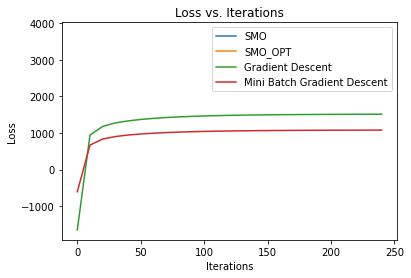

In [39]:
plt.plot(svm_smo.iter, svm_smo.loss,label ="SMO")
plt.plot(svm_smo_opt.iter, svm_smo_opt.loss,label ="SMO_OPT")
plt.plot(svm_dual.iter, svm_dual.loss,label ="Gradient Descent")
plt.plot(svm_batch.iter, svm_batch.loss,label ="Mini Batch Gradient Descent")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.show()